### Coursework coding instructions (please also see full coursework spec)

Please choose if you want to do either Task 1 or Task 2. You should write your report about one task only.

For the task you choose you will need to do two approaches:
  - Approach 1, which can use use pre-trained embeddings / models
  - Approach 2, which should not use any pre-trained embeddings or models
We should be able to run both approaches from the same colab file

#### Running your code:
  - Your models should run automatically when running your colab file without further intervention
  - For each task you should automatically output the performance of both models
  - Your code should automatically download any libraries required

#### Structure of your code:
  - You are expected to use the 'train', 'eval' and 'model_performance' functions, although you may edit these as required
  - Otherwise there are no restrictions on what you can do in your code

#### Documentation:
  - You are expected to produce a .README file summarising how you have approached both tasks

#### Reproducibility:
  - Your .README file should explain how to replicate the different experiments mentioned in your report

Good luck! We are really looking forward to seeing your reports and your model code!

# README

## Humor Regression Task

This notebook contains different implementations of a regression to task to predict the funniness score of headline data in which one word of the headline has been replaced. 

There are 4 implementations which are separated by title in the notebook and are in the following order:
1. Bi-LSTM with gloVe embedding
2. BERT 
3. No pretrained representations using cosine distance regression
4. No pretrained representations using Bi-LSTM

### Installation
All modules are imported at the top of the file and should be installed already when running on Google Colab, except for transformers. 
```python 
pip install transformers 
```
is also included in the notebook, so make sure to run this. The data is downloaded through URLs so no other files are necessary to run this notebook, it is entirely self contained.

### Running the notebook
For ease of use, some of the code has been duplicated throughout the notebook so that one can very easily run the code from top to bottom. The code has been separated into titled sections. Sections can be skipped - i.e. one can directly run BERT without running Bi-LSTM in part 1, or directly go to part 2 with no pretrained embeddings, as long as the data is downloaded and preprocessed, such that the code up until the end of "Data Preprocessing" has run. 


### Setup Code

In [1]:
# You will need to download any word embeddings required for your code, e.g.:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-02-25 09:14:43--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-02-25 09:14:43--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-02-25 09:14:43--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [2]:
! pip install transformers

     |████████████████████████████████| 1.9MB 9.7MB/s 
     |████████████████████████████████| 3.2MB 36.5MB/s 
     |████████████████████████████████| 890kB 62.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=532c85c220d3b0f845d3687bc1816cd7904c194b084c70487b3a4e423d086131
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
# Imports

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, random_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import codecs
from transformers import RobertaTokenizer, RobertaModel, BertTokenizer, BertModel, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
import spacy
import nltk
nltk.download('wordnet')
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from spacy.tokenizer import Tokenizer
import re
import pdb
import random
import csv
import tqdm
from tqdm import tqdm
import multiprocessing
import pickle
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import matplotlib.pyplot as plt
import os



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [4]:
# Setting random seed and device
SEED = 1

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cuda', index=0)

In [222]:
# Load data
%mkdir ./data
%cd ./data
import os

if not os.path.isfile('train.csv'):
    !wget -O train.csv https://www.dropbox.com/s/utcewlslgwm278m/train.csv?dl=0
if not os.path.isfile('dev.csv'):
    !wget -O dev.csv https://www.dropbox.com/s/0bpqmpb009ay717/dev.csv?dl=0
if not os.path.isfile('extra_train.csv'):
    !wget -O extra_train.csv https://www.dropbox.com/s/6bptu62w4uvhtkf/extra_train_data-3.csv?dl=0
if not os.path.isfile('truth_task_1.csv'):
    !wget -O truth_task_1.csv https://www.dropbox.com/s/p29wv4075zrcd7n/truth_task_1.csv?dl=0

%cd ..

train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/dev.csv')
extra_train = pd.read_csv('./data/extra_train.csv')
test_data = pd.read_csv('./data/truth_task_1.csv')


mkdir: cannot create directory ‘./data’: File exists
/content/data
/content


In [224]:
test_data

,id,original,edit,grades,meanGrade
0,36,The Latest : Election tally shows <Austria/> t...,Cars,31110,1.2
1,2157,House Intel <Republicans/> Have Cleared Trump ...,onions,11000,0.4
2,9385,Christmas Is Canceled : Nazareth ’s Muslim <Ma...,grump,11111,1.0
3,14434,White House says Trump 's legal <team/> suppor...,bozos,32210,1.6
4,9462,Election <analysts/> move Ryan seat toward Dem...,movers,11000,0.4
...,...,...,...,...,...
3019,3921,Sen. Bernie Sanders says he ’s “ sickened ” by...,mucus,33210,1.8
3020,12371,Trump Repeals Regulation Protecting <Workers/>...,Owners,30000,0.6
3021,6845,Spicer : We do n't regret repeating claim that...,licked,11000,0.4
3022,2902,Gunshots Fired Outside Houses of <Parliament/>...,dogs,0,0.0


In [226]:
(test_df + test_data).reset_index(drop=True).duplicated().sum()

604

In [6]:
#in case you want to run with extra training data, run this line
train_df = pd.concat([train_df, extra_train], ignore_index=True)

In [85]:
#Kevin
#%cd /content/drive/MyDrive/Colab Notebooks/NLP_Coursework/ic_nlp_cw
#train_df = pd.read_csv('./task-1/train.csv')
#test_df = pd.read_csv('./task-1/dev.csv')
#extra_train = pd.read_csv('./extra_train_data-3.csv')

[Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/NLP_Coursework/ic_nlp_cw'
/content


FileNotFoundError: ignored

# Approach 1: Pretrained representations

## Part 1 BILSTM

### Data PreProcessing

In [7]:
#get array of grades as labels
def get_grade_list(grades):
  grade_list = []
  for i, grade in enumerate(grades):
    list_grade = list(str(grade))
    grade_list.append(list(map(int, list_grade)))
  return grade_list
    

In [8]:
#add to be replaced word and edited word to dataframe and adjust column 'original' by removing special tokens
def add_columns_to_data(train_df, test_df):   
    #instead of having two inputs out of preprocessing, edit the dataset, and add in columns which we can use as inputs
    #we can also add an 'old' field which contains the original word 
    train_df['old'] = train_df.apply(lambda x:x['original'][x['original'].find('<')+1:x['original'].find('>')-1],axis=1)
    test_df['old'] = test_df.apply(lambda x:x['original'][x['original'].find('<')+1:x['original'].find('>')-1],axis=1)

    #first we add a field to the data which contains the edited headline
    train_df['edited'] = train_df.apply(lambda x:x['original'].replace(x['original'][x['original'].find('<'):x['original'].find('>')+1],x['edit'] ) ,axis=1)
    test_df['edited'] = test_df.apply(lambda x:x['original'].replace(x['original'][x['original'].find('<'):x['original'].find('>')+1], x['edit'] ) ,axis=1)

    train_df['original'] = train_df.apply(lambda x:x['original'].replace(x['original'][x['original'].find('<'):x['original'].find('>')+1], x['old']) ,axis=1)
    test_df['original'] = test_df.apply(lambda x:x['original'].replace(x['original'][x['original'].find('<'):x['original'].find('>')+1], x['old']),axis=1)

    grades = train_df["grades"].tolist()
    grade_lists = get_grade_list(grades)
    vars = [np.var(grade) for grade in grade_lists]
    train_df["variance"] = vars

    return train_df, test_df

In [9]:
train_df, test_df = add_columns_to_data(train_df, test_df)

In [28]:
# Number of epochs
epochs = 80

# Proportion of training data for train compared to dev
train_proportion = 0.8

### Creating Vocab and Tokenized Corpus

In [12]:
#use spacy stop_words that will be removed
nlp = spacy.load("en")
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [13]:
# Custom tokenizer that removes punctuation
def custom_tokenizer(nlp):
    
    replacement_re = re.compile(r'^<*/>') #do not split replacement format
    prefix_re = re.compile(r'''^[\[\("]''')
    suffix_re = re.compile(r''',[\]\)"']$''')
    infix_re = re.compile(r'''[-\,.~]''')
    
    
    return Tokenizer(nlp.vocab,
                     token_match = replacement_re.match,
                     prefix_search=prefix_re.search,
                     suffix_search=suffix_re.search,
                     infix_finditer = infix_re.finditer  
                    )


# Custom preprocessor that adds ??? token
def preprocessor(data,edits):
    """
    Creating a corpus of all the tokens used
    """
    from nltk.stem import WordNetLemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()  

    punctuation = "\":\.,"
    nlp = spacy.load("en_core_web_sm")
    nlp.tokenizer = custom_tokenizer(nlp)
    
    tokenized_corpus_1= [] # Let us put the tokenized corpus in a list
    tokenized_corpus_2= []
    
    
    for i, sentence in enumerate(data):

        sentence = sentence.lower()
        tokenized_sentence_1 = []
        tokenized_sentence_2 = []

        for token in nlp(sentence): # simplest split is

            if token.text in punctuation:
                continue
            if token.text in stop_words:
                continue
            
            else:
                if token.text[0] == '<':
                    tokenized_sentence_1.append("???")
                    tokenized_sentence_2.append("???")
                    
                    tokenized_sentence_2.append(wordnet_lemmatizer.lemmatize(edits.iloc[i],  pos="v"))

                    lemmatized_token = wordnet_lemmatizer.lemmatize(token.text[1:-2], pos="v")

                    tokenized_sentence_1.append(lemmatized_token)
                else:
                    lemmatized_token = wordnet_lemmatizer.lemmatize(token.text, pos="v")

                    tokenized_sentence_2.append(lemmatized_token)
                
                    tokenized_sentence_1.append(lemmatized_token)


        tokenized_corpus_1.append(tokenized_sentence_1)
        tokenized_corpus_2.append(tokenized_sentence_2)

    # Create single list of all vocabulary
    vocabulary = []  
    
    for sentence in tokenized_corpus_1:

        for token in sentence:

            if token not in vocabulary:

                if True:
                    vocabulary.append(token)
    
    for token in edits:
        
        if token not in vocabulary:
            
            vocabulary.append(token)

    return vocabulary, tokenized_corpus_1, tokenized_corpus_2

In [14]:
# We set our training data and test data
training_data = train_df['original']
test_data = test_df['original']

# Creating word vectors
training_vocab, training_tokenized_corpus_1,training_tokenized_corpus_2=  preprocessor(training_data,train_df['edit'])
test_vocab, test_tokenized_corpus_1,test_tokenized_corpus_2=  preprocessor(test_data,test_df['edit'])

print("Vocabulary individual creation - done")

# Creating joint vocab from test and train:
joint_vocab, joint_tokenized_corpus_1,joint_tokenized_corpus_2 = preprocessor(pd.concat([training_data, test_data]),pd.concat([train_df['edit'],test_df['edit']],ignore_index = True))

print("Vocabulary joined creation - done")



print("Vocab created.")

Vocabulary individual creation - done
Vocabulary joined creation - done
Vocab created.


In [15]:
# We create representations for our tokens
wvecs = [] # word vectors
word2idx = [] # word2index
idx2word = []

#Add special character -> embedding vector of ones 
wvecs.append(np.ones(100))

# This is a large file, it will take a while to load in the memory!
with codecs.open('glove.6B.100d.txt', 'r','utf-8') as f:
  index = 1 #zero padding
  for line in f.readlines():
    # Ignore the first line - first line typically contains vocab, dimensionality
    if len(line.strip().split()) > 3:
      word = line.strip().split()[0]
      if word in joint_vocab:
          (word, vec) = (word,
                     list(map(float,line.strip().split()[1:])))
          wvecs.append(vec)
          word2idx.append((word, index))
          idx2word.append((index, word))
          index += 1

wvecs = np.array(wvecs)
word2idx = dict(word2idx)
idx2word = dict(idx2word)





In [16]:
#add <unk> token to dictionaries and set embedding to mean of vocab embedding (will be called OOV token later)
word2idx['<unk>'] = 1
idx2word[1] = '<unk>'
mean = np.mean(wvecs, axis=0) # initialize unknown token as mean
wvecs[0] = mean


In [144]:
#build vectorized sequence of tokenized corpus that replaces unknown words by <unk> token

vectorized_seqs_1 = [[word2idx[tok] if tok in word2idx else word2idx['<unk>'] for tok in seq] for seq in training_tokenized_corpus_1]
vectorized_seqs_2 = [[word2idx[tok] if tok in word2idx else word2idx['<unk>'] for tok in seq] for seq in training_tokenized_corpus_2]

vectorized_seqs_1_test = [[word2idx[tok] if tok in word2idx else word2idx['<unk>'] for tok in seq] for seq in test_tokenized_corpus_1]
vectorized_seqs_2_test = [[word2idx[tok] if tok in word2idx else word2idx['<unk>'] for tok in seq] for seq in test_tokenized_corpus_2]


# To avoid any sentences being empty (if no words match to our word embeddings)
vectorized_seqs_1 = [x if len(x) > 0 else [0] for x in vectorized_seqs_1]
vectorized_seqs_2 = [x if len(x) > 0 else [0] for x in vectorized_seqs_2]

vectorized_seqs_1_test = [x if len(x) > 0 else [0] for x in vectorized_seqs_1_test]
vectorized_seqs_2_test = [x if len(x) > 0 else [0] for x in vectorized_seqs_2_test]



### Training for BILSTM

In [75]:
# We define our training loop
def train(train_iter, dev_iter, model, number_epoch, bert=False):
    """
    Training loop for the model, which calls on eval to evaluate after each epoch
    """

    train_losses = np.zeros(number_epoch)
    valid_losses = np.zeros(number_epoch)
    train_rmses = []
    valid_rmses = []
    print("Training model.")

    for epoch in range(1, number_epoch+1):

        model.train()
        epoch_loss = 0
        epoch_sse = 0
        no_observations = 0  # Observations used for training so far
        
        for batch in train_iter:
            optimizer.zero_grad()
            feature, target = batch
            feature_1= feature[0].to(device)
            feature_2 = feature[1].to(device)
            target = target.to(device)
            # for RNN:
            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]
            model.hidden_1 = model.init_hidden()
            model.hidden_2 = model.init_hidden()

            feature = (feature_1, feature_2)
            predictions = model(feature).squeeze(1)
            
            loss = loss_fn(predictions, target)
                        
            sse, __ = model_performance(predictions.detach().cpu().numpy(), target.detach().cpu().numpy()) 
            
            loss.backward(retain_graph=True)
            optimizer.step()

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse

        valid_loss, valid_mse, preds, targs = eval(dev_iter, model)

        epoch_loss, epoch_mse = epoch_loss / no_observations, epoch_sse / no_observations
        train_losses[epoch-1] = epoch_loss
        valid_losses[epoch-1] = valid_loss
        train_rmses.append(epoch_mse**0.5)
        valid_rmses.append(valid_mse**0.5)
        print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train MSE: {epoch_mse:.2f} | Train RMSE: {epoch_mse**0.5:.2f} | \
        Val. Loss: {valid_loss:.2f} | Val. MSE: {valid_mse:.2f} |  Val. RMSE: {valid_mse**0.5:.3f} |')
    return train_losses, valid_losses, preds, targs, train_rmses, valid_rmses

In [76]:
# We evaluate performance on our dev set
def eval(data_iter, model):
    """
    Evaluating model performance on the dev set
    """
    model.eval()
    epoch_loss = 0
    epoch_sse = 0
    pred_all = []
    trg_all = []
    no_observations = 0



    with torch.no_grad():
        for batch in data_iter:
            feature, target = batch
            feature_1= feature[0].to(device)
            feature_2 = feature[1].to(device)
            target = target.to(device)

            feature = (feature_1, feature_2)

            # for RNN:
            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]
            model.hidden_1 = model.init_hidden()
            model.hidden_2 = model.init_hidden()

            predictions = model(feature).squeeze(1)
            #predictions.requires_grad = True
            loss = loss_fn(predictions, target)

            # We get the mse
            pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
            sse, __ = model_performance(pred, trg)

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse
            pred_all.extend(pred)
            trg_all.extend(trg)

    return epoch_loss/no_observations, epoch_sse/no_observations, np.array(pred_all), np.array(trg_all)

In [77]:
# How we print the model performance
def model_performance(output, target, print_output=False):
    """
    Returns SSE and MSE per batch (printing the MSE and the RMSE)
    """

    sq_error = (output - target)**2

    sse = np.sum(sq_error)
    mse = np.mean(sq_error)
    rmse = np.sqrt(mse)

    if print_output:
        print(f'| MSE: {mse:.2f} | RMSE: {rmse:.2f} |')

    return sse, mse

In [78]:
#add padding
def collate_fn_padd(batch):
    
    #We add padding to our minibatches and create tensors for our model
    

    batch_labels = [l for f, g, l in batch]
    batch_features = [(f,g) for f, g, l in batch]
    

    batch_features_len = [len(f) for f, g, l in batch]


    seq_tensor_1 = torch.zeros((len(batch), 50)).long()
    seq_tensor_2 = torch.zeros((len(batch), 50)).long()

    
    for idx, (seq, seqlen) in enumerate(zip(batch_features, batch_features_len)):
        seq_tensor_1[idx, :seqlen] = torch.LongTensor(seq[0])
        seq_tensor_2[idx, :seqlen] = torch.LongTensor(seq[1])
    batch_labels = torch.FloatTensor(batch_labels)
    

    return (seq_tensor_1, seq_tensor_2), batch_labels


#class for representing data (adjusted to match two stream BILSTM)  
class Task1Dataset_double(Dataset):

    def __init__(self, train_data_1,train_data_2, labels):
        self.x_train_1 = train_data_1
        self.x_train_2 = train_data_2
        self.y_train = labels

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, item):
        return self.x_train_1[item],self.x_train_2[item], self.y_train[item]    


In [191]:
#Model architecture
class BiLSTM_double(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, batch_size, device):
        super(BiLSTM_double, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.device = device
        self.batch_size = batch_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm_1 = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)
        self.lstm_2 = nn.LSTM(embedding_dim,hidden_dim, bidirectional = True)

        # The linear layer that maps from hidden state space to tag space
        self.fc = nn.Linear(2*55*100, hidden_dim*2)
        #self.fc2 = nn.Linear(hidden_dim*2, hidden_dim//2)
        #self.fc3 = nn.Linear(hidden_dim//2, hidden_dim//4)

        self.hidden_1 = self.init_hidden()
        self.hidden_2 = self.init_hidden()
        self.hidden2label = nn.Linear(hidden_dim*2, 1)

        self.d1 = nn.Dropout(0.5)
        self.d2 = nn.Dropout(0.5)
        self.d3 = nn.Dropout(0.5)
        #self.d4 = nn.Dropout(0.3)
        #self.d5 = nn.Dropout(0.3)

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly why they have this dimensionality.
        # The axes semantics are (num_layers * num_directions, minibatch_size, hidden_dim)
        
        return torch.zeros(2, self.batch_size, self.hidden_dim, requires_grad = True).to(self.device), \
               torch.zeros(2, self.batch_size, self.hidden_dim, requires_grad = True).to(self.device)

    def forward(self, sentence):
        self.embedded_1 = self.embedding(sentence[0])
        self.embedded_1 = self.embedded_1.permute(1, 0, 2) #Needed for LSTMs

        self.embedded_2 = self.embedding(sentence[1])
        self.embedded_2 = self.embedded_2.permute(1, 0, 2) #Needed for LSTMs

        #lstm_out : (seq_len,batch_size,num_directions (2) * hidden_size (50))
        #hidden : (num_layers * num_directions, batch_size,hidden_size)
        lstm_out_1, self.hidden_1 = self.lstm_1(
            self.embedded_1.view(len(self.embedded_1), self.batch_size, self.embedding_dim), self.hidden_1)
        
        lstm_out_1 = F.leaky_relu(self.d1(lstm_out_1))

        lstm_out_2, self.hidden_2 = self.lstm_2(
            self.embedded_2.view(len(self.embedded_2), self.batch_size, self.embedding_dim), self.hidden_2)
        
        lstm_out_2 = F.leaky_relu(self.d2(lstm_out_2))
        
        #out : (1)
        lstm_out_1 = lstm_out_1.permute(1,0,2)
        lstm_out_2 = lstm_out_2.permute(1,0,2)

        out1 = self.fc(torch.cat((lstm_out_1.reshape(self.batch_size, -1),lstm_out_2.reshape(self.batch_size, -1)), dim = 1))
        out1 = F.leaky_relu(self.d3(out1))

        #out2 = self.fc2(out1)
        #out2 = F.leaky_relu(self.d4(out2))

        #out3 = self.fc3(out2)
        #out3 = F.leaky_relu(self.d5(out3))

        out = self.hidden2label(out1)
        out = torch.sigmoid(out)*3
        return out

In [208]:
#Initialize model

INPUT_DIM = len(word2idx)
EMBEDDING_DIM = wvecs.shape[1]

BATCH_SIZE = 128

model = BiLSTM_double(EMBEDDING_DIM, 55, INPUT_DIM, BATCH_SIZE, device)

params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(params)
#print("Total number of parameters is: {​​}​​".format(params))

print(model)

print("Model initialised.")

model.to(device)

model.embedding.weight.data.copy_(torch.from_numpy(wvecs))



2769481
BiLSTM_double(
  (embedding): Embedding(14211, 100, padding_idx=0)
  (lstm_1): LSTM(100, 55, bidirectional=True)
  (lstm_2): LSTM(100, 55, bidirectional=True)
  (fc): Linear(in_features=11000, out_features=110, bias=True)
  (hidden2label): Linear(in_features=110, out_features=1, bias=True)
  (d1): Dropout(p=0.5, inplace=False)
  (d2): Dropout(p=0.5, inplace=False)
  (d3): Dropout(p=0.5, inplace=False)
)
Model initialised.


tensor([[ 0.0027,  0.0846,  0.1260,  ..., -0.0692,  0.1462,  0.0768],
        [-1.2557,  0.6104,  0.5679,  ..., -1.5877,  0.7698, -0.6500],
        [-0.5426,  0.4148,  1.0322,  ..., -1.2969,  0.7622,  0.4635],
        ...,
        [ 0.0068,  0.0145, -0.3016,  ...,  0.5548, -0.1785,  0.0685],
        [ 0.1981, -0.0991, -0.2745,  ...,  0.1796, -0.3175,  0.1357],
        [ 0.1318,  0.0111, -0.1804,  ...,  0.1664, -0.2256,  0.3588]],
       device='cuda:0')

In [209]:
#function to plot train and validation loss over epochs
def plot(train_losses,valid_losses,num_epochs):
  epochs = list(range(num_epochs))
  plt.plot(epochs,train_losses, label='train')
  plt.plot(epochs,valid_losses, label='valid')
  plt.legend()
  plt.show()


In [210]:
#setup for training the model (create dataloaders etc.)

feature_1 = vectorized_seqs_1
feature_2 = vectorized_seqs_2

# 'feature' is a list of lists, each containing embedding IDs for word tokens
train_and_dev = Task1Dataset_double(feature_1,feature_2, train_df['meanGrade'])
#train_and_dev = Task1Dataset_double(feature_1,feature_2, train_df['variance'])

train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples
train_dataset, dev_dataset = random_split(train_and_dev,
                                           (train_examples,
                                            dev_examples))

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)



print("Dataloaders created.")

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)
#optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.SGD(model.parameters(), lr=0.008, momentum=0.9)


Dataloaders created.


### Results when predicting meanGrade



Dataloaders created.
Training model.
| Epoch: 01 | Train Loss: 0.37 | Train MSE: 0.37 | Train RMSE: 0.61 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.591 |
| Epoch: 02 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.590 |
| Epoch: 03 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.589 |
| Epoch: 04 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.589 |
| Epoch: 05 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.589 |
| Epoch: 06 | Train Loss: 0.35 | Train MSE: 0.35 | Train RMSE: 0.60 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.588 |
| Epoch: 07 | Train Loss: 0.35 | Train MSE: 0.35 | Train RMSE: 0.60 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.588 |
| Epoch: 08 | Train Loss: 0.35 |

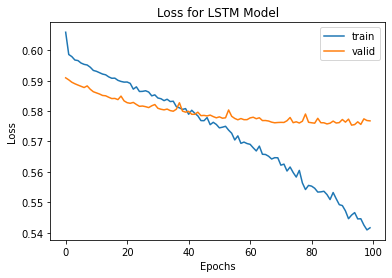

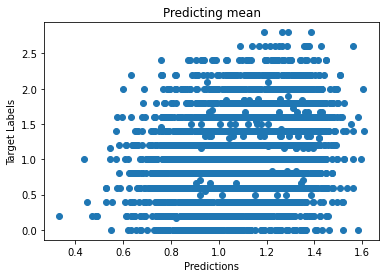

In [211]:
#train model
feature_1 = vectorized_seqs_1
feature_2 = vectorized_seqs_2


# 'feature' is a list of lists, each containing embedding IDs for word tokens
train_and_dev = Task1Dataset_double(feature_1,feature_2, train_df['meanGrade'])
#train_and_dev = Task1Dataset_double(feature_1,feature_2, train_df['variance'])

train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples
train_dataset, dev_dataset = random_split(train_and_dev,
                                           (train_examples,
                                            dev_examples))
####Shuffle might need to be true. Check later
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

print("Dataloaders created.")

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)
#optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.SGD(model.parameters(), lr=0.008, momentum=0.8)


train_losses, valid_losses, preds, targs, train_rmses, valid_rmses = train(train_loader, dev_loader, model, 100)
plt.title("Loss for LSTM Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plot(train_rmses, valid_rmses, len(train_rmses))
plt.scatter(preds, targs)
plt.title("Predicting mean")
plt.xlabel("Predictions")
plt.ylabel("Target Labels")
plt.show()


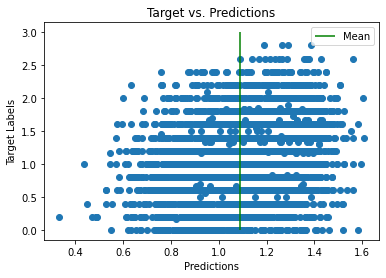

In [212]:
plt.scatter(preds, targs)
mean = np.mean(train_df["meanGrade"].tolist())
plt.title("Target vs. Predictions")
plt.vlines(mean, ymin = 0, ymax = 3, label="Mean", color = "green")
plt.legend()
plt.xlabel("Predictions")
plt.ylabel("Target Labels")
plt.show()


In [213]:
test_dataset = Task1Dataset_double(vectorized_seqs_1_test,vectorized_seqs_2_test, train_df.meanGrade)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=len(test_df), collate_fn=collate_fn_padd)

In [ ]:
test_loss, test_mse, predictions, targets = eval(test_loader, model)
mse = np.mean((predictions - targets)**2)
rmse = mse ** 0.5
print('Test rmse is {}'.format(rmse))

In [ ]:
plt.scatter(predictions, targets)
plt.title("Target vs. Predictions - Test set")

plt.legend()
plt.xlabel("Predictions")
plt.ylabel("Target Labels")
plt.show()

In [214]:
model.eval()

with torch.no_grad():
    for batch in test_loader:
        feature, target = batch
        feature_1= feature[0].to(device)
        feature_2 = feature[1].to(device)

        feature = (feature_1, feature_2)

        # for RNN:
        model.batch_size = target.shape[0]
        model.hidden_1 = model.init_hidden()
        model.hidden_2 = model.init_hidden()

        predictions = model(feature).squeeze(1)

        #predictions_plot.append(predictions.detach().cpu().numpy())
        #target_plot.append(target.detach().cpu().numpy())

predictions

tensor([0.8115, 1.3345, 1.1184,  ..., 1.2887, 1.0883, 1.0830], device='cuda:0')

<function matplotlib.pyplot.show>

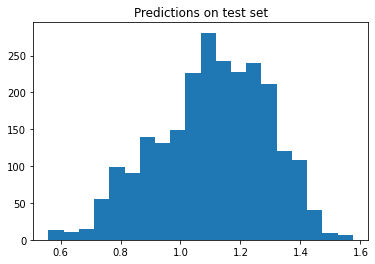

In [219]:
plt.hist(predictions.cpu().numpy(), bins = 20)

plt.title("Predictions on test set")

plt.show

### Further exploration with Variance

#### Predicting the Variance

Dataloaders created.
Training model.
| Epoch: 01 | Train Loss: 0.40 | Train MSE: 0.40 | Train RMSE: 0.63 |         Val. Loss: 0.29 | Val. MSE: 0.29 |  Val. RMSE: 0.54 |
| Epoch: 02 | Train Loss: 0.24 | Train MSE: 0.24 | Train RMSE: 0.49 |         Val. Loss: 0.20 | Val. MSE: 0.20 |  Val. RMSE: 0.45 |
| Epoch: 03 | Train Loss: 0.20 | Train MSE: 0.20 | Train RMSE: 0.44 |         Val. Loss: 0.18 | Val. MSE: 0.18 |  Val. RMSE: 0.43 |
| Epoch: 04 | Train Loss: 0.19 | Train MSE: 0.19 | Train RMSE: 0.43 |         Val. Loss: 0.18 | Val. MSE: 0.18 |  Val. RMSE: 0.43 |
| Epoch: 05 | Train Loss: 0.19 | Train MSE: 0.19 | Train RMSE: 0.43 |         Val. Loss: 0.18 | Val. MSE: 0.18 |  Val. RMSE: 0.43 |
| Epoch: 06 | Train Loss: 0.19 | Train MSE: 0.19 | Train RMSE: 0.43 |         Val. Loss: 0.18 | Val. MSE: 0.18 |  Val. RMSE: 0.43 |
| Epoch: 07 | Train Loss: 0.19 | Train MSE: 0.19 | Train RMSE: 0.43 |         Val. Loss: 0.18 | Val. MSE: 0.18 |  Val. RMSE: 0.43 |
| Epoch: 08 | Train Loss: 0.19 | Train 

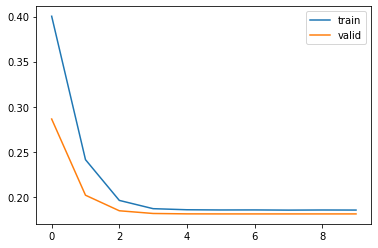

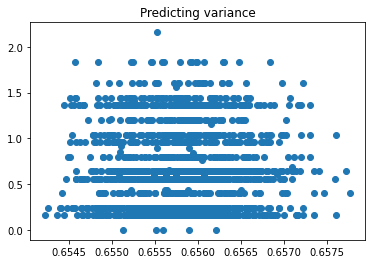

In [ ]:
#train model when only predicting variance
feature_1 = vectorized_seqs_1
feature_2 = vectorized_seqs_2


# 'feature' is a list of lists, each containing embedding IDs for word tokens
#train_and_dev = Task1Dataset_double(feature_1,feature_2, train_df['meanGrade'])
train_and_dev = Task1Dataset_double(feature_1,feature_2, train_df['variance'])

train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples
train_dataset, dev_dataset = random_split(train_and_dev,
                                           (train_examples,
                                            dev_examples))

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

print("Dataloaders created.")

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)
#optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


train_losses, valid_losses, preds, targs = train(train_loader, dev_loader, model, epochs)
plot(train_losses, valid_losses, len(train_losses))
plt.scatter(preds, targs)
plt.title("Predicting variance")
plt.show()


#### Predicting the mean with high variance data

In [ ]:
#drop low variance
indexNames = train_df[(train_df['variance'] < 0.3)].index
# Delete these row indexes from dataFrame
high_v_train = train_df.drop(indexNames, inplace=False)
high_v_train = high_v_train.reset_index(inplace=False,drop=True)

In [ ]:
high_v_train

,id,original,edit,grades,meanGrade,old,edited,variance
0,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6,Syria,"Pentagon claims 2,000 % increase in Russian tr...",1.44
1,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0,Coalition,Iceland PM Calls Snap Vote as Pedophile Furor ...,0.80
2,76,"In an apparent first , Iran and Israel engage ...",slap,20000,0.4,engage,"In an apparent first , Iran and Israel slap ea...",0.64
3,8832,All 22 promises Trump made in his speech to Co...,sounds,22200,1.2,promises,All 22 sounds Trump made in his speech to Cong...,0.96
4,12174,New DOJ alert system will flag crimes against ...,laughter,32100,1.2,crimes,New DOJ alert system will flag laughter agains...,1.36
...,...,...,...,...,...,...,...,...
6297,7544,This Is What Happens When You Let Trump Be Trump,orange,33211,2.0,Trump,This Is What Happens When You Let Trump Be ora...,0.80
6298,12770,"Among Republicans , Trump is more popular than...",interns,21100,0.8,leaders,"Among Republicans , Trump is more popular than...",0.56
6299,1781,Protesters Rally for Refugees Detained at JFK ...,stewardesses,20000,0.4,Refugees,Protesters Rally for stewardesses Detained at ...,0.64
6300,5628,Cruise line Carnival Corp. joins the fight aga...,raisin,21000,0.6,marriage,Cruise line Carnival Corp. joins the fight aga...,0.64


Dataloaders created.
Training model.
| Epoch: 01 | Train Loss: 1.03 | Train MSE: 1.03 | Train RMSE: 1.01 |         Val. Loss: 0.77 | Val. MSE: 0.77 |  Val. RMSE: 0.88 |
| Epoch: 02 | Train Loss: 0.56 | Train MSE: 0.56 | Train RMSE: 0.75 |         Val. Loss: 0.40 | Val. MSE: 0.40 |  Val. RMSE: 0.63 |
| Epoch: 03 | Train Loss: 0.32 | Train MSE: 0.32 | Train RMSE: 0.56 |         Val. Loss: 0.26 | Val. MSE: 0.26 |  Val. RMSE: 0.51 |
| Epoch: 04 | Train Loss: 0.25 | Train MSE: 0.25 | Train RMSE: 0.50 |         Val. Loss: 0.23 | Val. MSE: 0.23 |  Val. RMSE: 0.48 |
| Epoch: 05 | Train Loss: 0.23 | Train MSE: 0.23 | Train RMSE: 0.48 |         Val. Loss: 0.22 | Val. MSE: 0.22 |  Val. RMSE: 0.47 |
| Epoch: 06 | Train Loss: 0.23 | Train MSE: 0.23 | Train RMSE: 0.48 |         Val. Loss: 0.22 | Val. MSE: 0.22 |  Val. RMSE: 0.47 |
| Epoch: 07 | Train Loss: 0.23 | Train MSE: 0.23 | Train RMSE: 0.48 |         Val. Loss: 0.22 | Val. MSE: 0.22 |  Val. RMSE: 0.47 |
| Epoch: 08 | Train Loss: 0.23 | Train 

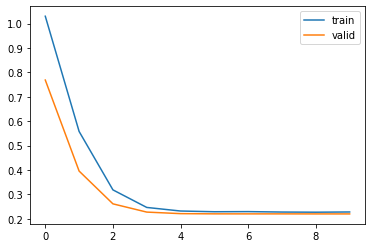

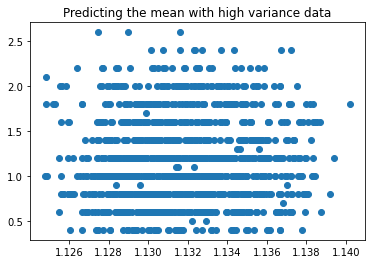

In [ ]:
#train model on high variance data
feature_1 = vectorized_seqs_1
feature_2 = vectorized_seqs_2


# 'feature' is a list of lists, each containing embedding IDs for word tokens
train_and_dev = Task1Dataset_double(feature_1,feature_2, high_v_train['meanGrade'])
#train_and_dev = Task1Dataset_double(feature_1,feature_2, train_df['variance'])

train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples
train_dataset, dev_dataset = random_split(train_and_dev,
                                           (train_examples,
                                            dev_examples))
####Shuffle might need to be true. Check later
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

print("Dataloaders created.")

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)
#optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


train_losses, valid_losses, preds, targs = train(train_loader, dev_loader, model, epochs)
plot(train_losses, valid_losses, len(train_losses))
plt.scatter(preds, targs)
plt.title("Predicting the mean with high variance data")
plt.show()


#### Predicting the mean with low variance data

In [ ]:
#drop high variance data
indexNames = train_df[(train_df['variance'] > 1)].index
# Delete these row indexes from dataFrame
low_v_train = train_df.drop(indexNames, inplace=False)
low_v_train = low_v_train.reset_index(inplace=False,drop=True)

Dataloaders created.
Training model.
| Epoch: 01 | Train Loss: 0.99 | Train MSE: 0.99 | Train RMSE: 0.99 |         Val. Loss: 0.46 | Val. MSE: 0.46 |  Val. RMSE: 0.68 |
| Epoch: 02 | Train Loss: 0.39 | Train MSE: 0.39 | Train RMSE: 0.63 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.60 |
| Epoch: 03 | Train Loss: 0.37 | Train MSE: 0.37 | Train RMSE: 0.61 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 04 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 05 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 06 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 07 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 08 | Train Loss: 0.36 | Train 

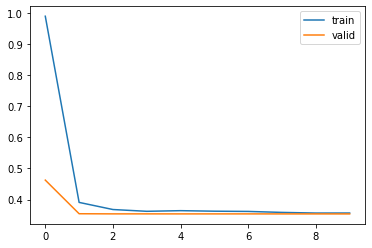

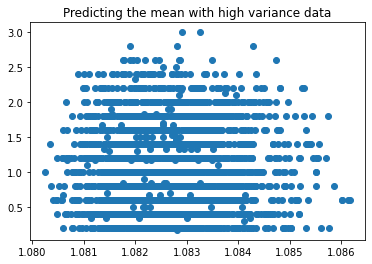

In [ ]:
#train model on low variance data
feature_1 = vectorized_seqs_1
feature_2 = vectorized_seqs_2


# 'feature' is a list of lists, each containing embedding IDs for word tokens
train_and_dev = Task1Dataset_double(feature_1,feature_2, low_v_train['meanGrade'])
#train_and_dev = Task1Dataset_double(feature_1,feature_2, train_df['variance'])

train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples
train_dataset, dev_dataset = random_split(train_and_dev,
                                           (train_examples,
                                            dev_examples))
####Shuffle might need to be true. Check later
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

print("Dataloaders created.")

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)
#optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


train_losses, valid_losses, preds, targs = train(train_loader, dev_loader, model, epochs)
plot(train_losses, valid_losses, len(train_losses))
plt.scatter(preds, targs)
plt.title("Predicting the mean with high variance data")
plt.show()


## Part 1 BERT 

### Bert Preprocessing

In [ ]:
#convert dataframe to list function
def data_to_list(data, training = True):  
  og_headline_list = data['original'].tolist()
  edited_headline_list = data['edited'].tolist()
  edited_word_list = data['edit'].tolist()
  labels_list = None

  if training:
    labels_list = data['meanGrade'].tolist()
  

  return og_headline_list, edited_headline_list, edited_word_list, labels_list

In [ ]:
train_og_headlines, train_edited_headlines, train_edited_words, labels = data_to_list(train_df)
test_og_headlines, test_edited_headlines, test_edited_words, test_labels = data_to_list(test_df, training=True)

In [ ]:
#preprocessing function for BERT
def preprocessing(data_list):
  preprocessed_data = []

  for sentence in data_list:

    sentence = re.sub(r'[^\w\s\?\!]', '', sentence)
    sentence = sentence.lower()
    preprocessed_data.append(sentence)
    
  return preprocessed_data

train_og_headlines_p = preprocessing(train_og_headlines)
train_edited_headlines_p = preprocessing(train_edited_headlines)
train_edited_words_p = preprocessing(train_edited_words)

test_og_headlines_p = preprocessing(test_og_headlines)
test_edited_headlines_p = preprocessing(test_edited_headlines)
test_edited_words_p = preprocessing(test_edited_words)

In [ ]:
#Load pretrained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# the version that concatenates original sentences and new sentences
train_encoded_inputs = tokenizer(train_og_headlines_p, train_edited_headlines_p, padding='max_length', max_length=90, truncation=True, return_tensors="pt")
test_encoded_inputs = tokenizer(test_og_headlines_p, test_edited_headlines_p, padding='max_length', max_length=90, truncation=True, return_tensors="pt")

In [ ]:
#assign specific columns to arrays
train_input_ids = train_encoded_inputs['input_ids']
train_attention_mask = train_encoded_inputs['attention_mask']
train_token_type_ids = train_encoded_inputs['token_type_ids']
train_labels = torch.tensor(labels)

train_token_type_ids[0]
tokenizer.decode(train_input_ids.tolist()[1])

'[CLS] pentagon claims 2000 increase in russian trolls after syria strikes what does that mean? [SEP] pentagon claims 2000 increase in russian trolls after bowling strikes what does that mean? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

### Bert Training/Eval


In [ ]:
#Hyperparameters
train_proportion = 0.8
batch_size = 16
lr = 5e-5
eps = 1e-8
epochs = 2

In [ ]:
#Bert dataset class 
class BERT_Dataset(torch.utils.data.Dataset):
    def __init__(self, x1, x2, x3, y1):
        self.len = x1.shape[0]

        self.x1_data = x1.to(device)
        self.x2_data = x2.to(device)
        self.x3_data = x3.to(device)
        self.y1_data = y1.to(device)


    def __getitem__(self, index):
        return self.x1_data[index], self.x2_data[index], self.x3_data[index], self.y1_data[index]


    def __len__(self):
        return self.len

In [ ]:
#create Bert dataloaders
train_and_dev = BERT_Dataset(train_input_ids, train_attention_mask, train_token_type_ids, train_labels)
train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples
train_dataset, dev_dataset = random_split(train_and_dev,(train_examples,dev_examples))


train_iter = DataLoader(
            train_dataset, 
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size
        )


eval_iter = DataLoader(
            dev_dataset, 
            sampler = SequentialSampler(dev_dataset), # Pull out batches sequentially.
            batch_size = batch_size 
        )

In [ ]:
test_input_ids = test_encoded_inputs['input_ids']
test_attention_mask = test_encoded_inputs['attention_mask']
test_token_type_ids = test_encoded_inputs['token_type_ids']
test_labels = torch.tensor(labels)
test_dataset = BERT_Dataset(train_input_ids, train_attention_mask, train_token_type_ids, train_labels)

In [ ]:
#initialize model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', # the 12-layer BERT model, with an uncased vocab.
    num_labels = 1,  
    output_attentions = False, # don't return attention weights or hidden states
    output_hidden_states = False, 
)
model.cuda()
#store double values
model = model.double()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
#setup optimizer and scheduler
optimizer = AdamW(model.parameters(), lr = lr, eps = eps)

total_steps = len(train_iter) * epochs
# The scheduler can actually learn the best learning rate throughout tranining
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [ ]:
# We define our training loop
def train(train_iter, dev_iter, model, number_epoch):
    """
    Training loop for the model, which calls on eval to evaluate after each epoch
    """

    train_losses = np.zeros(number_epoch)
    valid_losses = np.zeros(number_epoch)
    rmses = np.zeros(number_epoch)
    print("Training model.")


    for epoch in range(1, number_epoch+1):

        model.train()
        epoch_loss = 0
        epoch_sse = 0
        epoch_mse = 0
        no_observations = 0  # Observations used for training so far

        for input_ids_batch, attention_mask_batch, token_type_ids_batch, target in train_iter:
            optimizer.zero_grad()

            # get the output
            outputs = model(input_ids_batch,
                            attention_mask=attention_mask_batch,
                            token_type_ids=token_type_ids_batch)
            
            
            predictions = outputs[0].squeeze(1)
            loss = torch.sqrt(((predictions - target)**2).mean())


            no_observations = no_observations + target.shape[0]
         
            sse, mse, _ = model_performance(predictions.detach().cpu().numpy(), target.detach().cpu().numpy()) 
            
            loss.backward()
            optimizer.step()
            #Update the learning rate.
            scheduler.step()

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse 
            epoch_mse += mse * target.shape[0]

        valid_loss, valid_mse, preds, targs = eval(dev_iter, model)

        epoch_loss, epoch_mse = epoch_loss / no_observations, epoch_mse / no_observations

        train_losses[epoch-1] = epoch_loss
        valid_losses[epoch-1] = valid_loss
        rmses[epoch-1] = np.sqrt(epoch_mse)
        print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train MSE: {epoch_mse:.2f} | Train RMSE: {np.sqrt(epoch_mse):.2f} | \
        Val. Loss: {valid_loss:.2f} | Val. MSE: {valid_mse:.2f} |  Val. RMSE: {np.sqrt(valid_mse):.2f} |')
    return train_losses, valid_losses, rmses, preds, targs

In [ ]:
from sklearn.metrics import mean_squared_error
# We evaluate performance on our dev set
def eval(dev_iter, model):
    """
    Evaluating model performance on the dev set
    """
    model.eval()
    epoch_loss = 0
    epoch_sse = 0
    epoch_mse = 0
    pred_all = []
    trg_all = []
    no_observations = 0
    total_eval_loss = 0


    with torch.no_grad():
        for input_ids_batch, attention_mask_batch, token_type_ids_batch, target in dev_iter:

            no_observations = no_observations + target.shape[0]

            outputs = model(input_ids_batch,
                            attention_mask=attention_mask_batch,
                            token_type_ids=token_type_ids_batch)
            
            #loss, predictions = outputs[:2] 
            predictions = outputs[0].squeeze(1)
            loss = torch.sqrt(((predictions - target)**2).mean())
 
            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # We get the mse
            pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
            sse, mse, rmse = model_performance(pred, trg)

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse
            epoch_mse += mse*target.shape[0]
            pred_all.extend(pred)
            trg_all.extend(trg)
    

    return epoch_loss/no_observations, epoch_mse/no_observations, np.array(pred_all), np.array(trg_all)

In [ ]:
# How we print the model performance
def model_performance(output, target, print_output=False):
    """
    Returns SSE and MSE per batch (printing the MSE and the RMSE)
    """

    sq_error = (output - target)**2

    sse = np.sum(sq_error)
    mse = np.mean(sq_error)
    rmse = np.sqrt(mse)

    if print_output:
        print(f'| MSE: {mse:.2f} | RMSE: {rmse:.2f} |')

    return sse, mse, rmse

In [ ]:
#will be used as loss
def calculate_rmse(predictions, labels):
    loss = torch.sqrt(((predictions - labels)**2).mean())

    return loss

In [ ]:
#plot helper function
def plot(num_epochs, train_rmses, valid_rmses):
  epochs = list(range(num_epochs))
  plt.plot(epochs,train_rmses, label='train')
  plt.plot(epochs,valid_rmses, label='valid')
  plt.legend()
  plt.title("BERT Loss Curve")
  plt.xlabel("Epochs")
  plt.ylabel("RMSE Loss")
  plt.show()

In [ ]:
# Set the seed value all over the place to make this reproducible.
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True

train_losses, valid_losses, rmses, preds, targs= train(train_iter, eval_iter, model, epochs)
 

Training model.
| Epoch: 01 | Train Loss: 0.58 | Train MSE: 0.34 | Train RMSE: 0.59 |         Val. Loss: 0.53 | Val. MSE: 0.28 |  Val. RMSE: 0.53 |
| Epoch: 02 | Train Loss: 0.46 | Train MSE: 0.22 | Train RMSE: 0.47 |         Val. Loss: 0.52 | Val. MSE: 0.28 |  Val. RMSE: 0.53 |


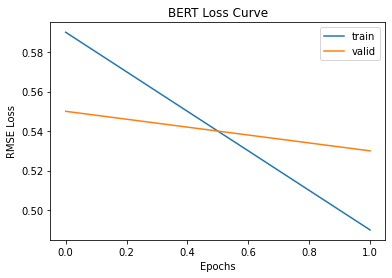

In [ ]:
plot(2, [0.59,0.49], [0.55,0.53])


1.087227701929302


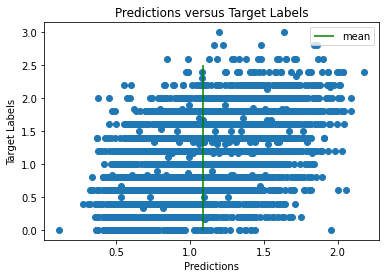

In [ ]:
#plot predictions vs target labels
plt.scatter(preds,targs)
plt.title("Predictions versus Target Labels")
plt.xlabel("Predictions")
plt.ylabel("Target Labels")
mean = np.mean(train_df["meanGrade"].tolist())
plt.vlines(mean, ymin = 0, ymax = 2.5, color = 'green', label = "mean")
plt.legend()
print(np.max(preds) - mean)


# Approach 2: No pre-trained representations

## Building a word embedding - Gutenberg

In [89]:
#Setup
nlp = spacy.load("en")
#GUTENBERG_DIR = "/content/drive/MyDrive/Colab Notebooks/NLP_Coursework/ic_nlp_cw/gutenberg"
#Consti
GUTENBERG_DIR = "/content/drive/MyDrive/Imperial_College/NLP_CW/ic_nlp_cw/gutenberg"

#Kevin
#%cd /content/drive/MyDrive/Colab Notebooks/NLP_Coursework/ic_nlp_cw
#train_df = pd.read_csv('./task-1/train.csv')
#test_df = pd.read_csv('./task-1/dev.csv')
#extra_train = pd.read_csv('./extra_train_data-3.csv')

lemma = True
stemming = False

wordnet_lemmatizer = WordNetLemmatizer()

%pwd

'/content'

In [90]:
#Preprocess headlines

#get pre preprocessing for BILSTM later
train_embedding_df_pre, dev_embedding_df_pre = train_test_split(train_df, test_size=0.2)

train_embedding_df_pre = train_embedding_df_pre.reset_index()
dev_embedding_df_pre = dev_embedding_df_pre.reset_index()

train_embedding_df, dev_embedding_df = train_embedding_df_pre.copy(), dev_embedding_df_pre.copy()

train_embedding_df['old'] = train_embedding_df.apply(lambda x:x['original'][x['original'].find('<')+1:x['original'].find('>')-1],axis=1)
train_embedding_df['original'] = train_embedding_df.apply(lambda x:x['original'].replace(x['original'][x['original'].find('<'):x['original'].find('>')+1], x['old']) ,axis=1)

dev_embedding_df['old'] = dev_embedding_df.apply(lambda x:x['original'][x['original'].find('<')+1:x['original'].find('>')-1],axis=1)
dev_embedding_df['original'] = dev_embedding_df.apply(lambda x:x['original'].replace(x['original'][x['original'].find('<'):x['original'].find('>')+1], x['old']) ,axis=1)


In [11]:
#Using 18 books Gutenberg Corpus
gutenberg_books = []
for i, book_name in enumerate(os.listdir(GUTENBERG_DIR)):
    book_file = open(os.path.join(
        GUTENBERG_DIR, book_name), encoding="latin-1")
    book = book_file.read()
    gutenberg_books.append(book)
    book_file.close()
    #if i == 1:
    #    break

gutenberg_book_lines = []
for book in gutenberg_books:
    book_lines = book.split("\n")
    book_lines = list(filter(lambda x: x != "", book_lines))
    #print(book_lines)
    gutenberg_book_lines.append(book_lines)
    
print(gutenberg_book_lines[:5])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [12]:
#Takes Gutenberg books and tokenizes corpus
tokenized_corpus = []
for book_line in tqdm(gutenberg_book_lines):
    for line in book_line:
        doc = nlp(line)
        tokenized_corpus.append([token.text.lower() for token in doc if not token.is_punct])
print(tokenized_corpus[:3])

#Use pickle to save corpus to disk
pickle.dump(tokenized_corpus, open("tokenized_corpus_gutenberg.pkl", "wb"))


100%|██████████| 19/19 [27:16<00:00, 86.13s/it]


[['the', 'tragedie', 'of', 'macbeth', 'by', 'william', 'shakespeare', '1603'], ['actus', 'primus', 'scoena', 'prima'], ['thunder', 'and', 'lightning', 'enter', 'three', 'witches']]


In [91]:
#Load corpus from disk if previously pickled
tokenized_corpus = pickle.load(open("tokenized_corpus_gutenberg.pkl", "rb"))

In [92]:
#Remove stopwords from corpus
spacy_stop_words = spacy.lang.en.stop_words.STOP_WORDS
stemmer = PorterStemmer()

tokenized_corpus_rmSW = []
for sentence in tqdm(tokenized_corpus):
  if stemming:
    tokenized_corpus_rmSW.append([stemmer.stem(token) for token in sentence if token not in spacy_stop_words])
  elif lemma:
    tokenized_corpus_rmSW.append([wordnet_lemmatizer.lemmatize(token) for token in sentence if token not in spacy_stop_words])
  else: 
    tokenized_corpus_rmSW.append([token for token in sentence if token not in spacy_stop_words])
tokenized_corpus = tokenized_corpus_rmSW
print(tokenized_corpus[:3])
print(len(tokenized_corpus))

if stemming:
  pickle.dump(tokenized_corpus, open("tokenized_corpus_gutenberg_SW_stemmed.pkl", "wb"))
elif lemma:
  pickle.dump(tokenized_corpus, open("tokenized_corpus_gutenberg_SW_lemma.pkl", "wb"))
else:
  pickle.dump(tokenized_corpus, open("tokenized_corpus_gutenberg_SW.pkl", "wb"))

100%|██████████| 266179/266179 [00:05<00:00, 46353.80it/s]


[['tragedie', 'macbeth', 'william', 'shakespeare', '1603'], ['actus', 'primus', 'scoena', 'prima'], ['thunder', 'lightning', 'enter', 'witch']]
266179


In [93]:
#Remove stop words from Headlines
spacy_stop_words = spacy.lang.en.stop_words.STOP_WORDS

tokenized_headlines = []
for headline in tqdm(train_embedding_df.original):

  tokenized_sentence = []
  doc = nlp(headline)
  for token in doc:
    if token.text not in spacy_stop_words and not token.is_punct:

      if stemming:
        tokenized_sentence.append(stemmer.stem(token.text.lower()))
      elif lemma:
        tokenized_sentence.append(wordnet_lemmatizer.lemmatize(token.text.lower())) 
      else:
        tokenized_sentence.append(token.text.lower())
  tokenized_headlines.append(tokenized_sentence)
print(len(tokenized_headlines))
print(tokenized_headlines[:3])

if stemming:
  pickle.dump(tokenized_headlines, open("tokenized_corpus_headlines_stemmed.pkl", "wb"))
elif lemma:
  pickle.dump(tokenized_headlines, open("tokenized_corpus_headlines_lemma.pkl", "wb"))
else:
  pickle.dump(tokenized_headlines, open("tokenized_corpus_headlines.pkl", "wb"))

100%|██████████| 7721/7721 [01:06<00:00, 116.63it/s]


7721
[['three', 'gangster', 'killed', 'moscow', 'courthouse', 'firefight'], ['north', 'korea', 'call', 'u', 'aircraft', 'carrier', 'dispatch', 'outrageous'], ['russian', 'prime', 'minister', 'slam', 'trump', 'administration', 'weakness', 'over', 'u.s.', 'sanction']]


In [94]:

#Leave this out -> network would otherwise learn that edit is part of the embedding
edit_corpus = []
for word in tqdm(train_embedding_df.edit):
    doc = nlp(word)
    if stemming:
      edit_corpus.append(stemmer.stem(doc.text.lower())) 
    elif lemma:
      edit_corpus.append(wordnet_lemmatizer.lemmatize(doc.text.lower())) 
    else:
      edit_corpus.append(doc.text.lower())

if stemming:
  pickle.dump(edit_corpus, open("tokenized_edit_corpus_stemmed.pkl", "wb"))
elif lemma:
  pickle.dump(edit_corpus, open("tokenized_edit_corpus_lemma.pkl", "wb"))
else:
  pickle.dump(edit_corpus, open("tokenized_edit_corpus.pkl", "wb"))

100%|██████████| 7721/7721 [00:54<00:00, 142.90it/s]


In [95]:
#load corresponding corpi
if stemming:
  tokenized_corpus = pickle.load(open("tokenized_corpus_gutenberg_SW_stemmed.pkl", "rb"))
  tokenized_headlines = pickle.load(open("tokenized_corpus_headlines_stemmed.pkl", "rb"))
  edit_corpus = pickle.load(open("tokenized_edit_corpus_stemmed.pkl", "rb"))
elif lemma:
  tokenized_corpus = pickle.load(open("tokenized_corpus_gutenberg_SW_lemma.pkl", "rb"))
  tokenized_headlines = pickle.load(open("tokenized_corpus_headlines_lemma.pkl", "rb"))
  edit_corpus = pickle.load(open("tokenized_edit_corpus_lemma.pkl", "rb"))

else:
  tokenized_corpus = pickle.load(open("tokenized_corpus_gutenberg_SW.pkl", "rb"))
  tokenized_headlines = pickle.load(open("tokenized_corpus_headlines.pkl", "rb"))
  edit_corpus = pickle.load(open("tokenized_edit_corpus.pkl", "rb"))

print(len(tokenized_corpus))
print(len(tokenized_headlines))

266179
7721


In [96]:
#Combine corpus
tokenized_corpus = tokenized_corpus + tokenized_headlines #+  edit_corpus

In [97]:
#Save full corpus
if stemming:
  pickle.dump(tokenized_corpus, open("tokenized_corpus_gutenberg_full_stemmed.pkl", "wb"))
elif lemma:
  pickle.dump(tokenized_corpus, open("tokenized_corpus_gutenberg_full_lemma.pkl", "wb"))
else:
  pickle.dump(tokenized_corpus, open("tokenized_corpus_gutenberg_full.pkl", "wb"))

In [98]:
#Load full corpus from pickle
if stemming:
  tokenized_corpus = pickle.load(open("tokenized_corpus_gutenberg_full_stemmed.pkl", "rb"))
elif lemma:
  tokenized_corpus = pickle.load(open("tokenized_corpus_gutenberg_full_lemma.pkl", "rb"))
else:
  tokenized_corpus = pickle.load(open("tokenized_corpus_gutenberg_full.pkl", "rb"))

In [99]:
#add special token for BILSTM
for i in range(3):
  tokenized_corpus.append('???')
    
pickle.dump(tokenized_corpus, open("tokenized_corpus_gutenberg.pkl", "wb"))


In [100]:
#maybe change cut off frequency (all words less than cutoff not relevant -> too many unknowns in this case)
def get_vocabulary(tokenized_corpus, cutoff_frequency=1):
    vocab_freq_dict = dict()
    for sentence in tokenized_corpus:
        for token in sentence:

            if token not in vocab_freq_dict.keys():
                vocab_freq_dict[token] = 0

            vocab_freq_dict[token] += 1

    vocabulary = set()
    for sentence in tokenized_corpus:
        for token in sentence:

            if vocab_freq_dict[token] > cutoff_frequency:
                vocabulary.add(token)
                
    return vocabulary

vocabulary = get_vocabulary(tokenized_corpus)
print("LENGTH OF VOCAB:", len(vocabulary), "\nVOCAB:", vocabulary)
#No stemming or lemmatization, just punc removal
#Before stop word removal 32670
#With stop words removal 32393

LENGTH OF VOCAB: 31438 
VOCAB: {'mcgahn', 'unwarranted', 'derick', 'milling', '3:47', 'forme', "corner'd", 'fleet', 'y.', 'swalloweth', '33:24', 'appropriated', 'destroyed', '59:7', 'lord', 'timbrel', 'attributed', 'conceivable', '7:54', 'ammon', 'trotting', 'goad', 'o', 'straightforward', 'goeth', 'strategic', 'urgent', 'spiro', 'playground', 'sammy', '51:8', 'booby', 'surmised', 'irregular', 'contributed', 'camillo', '234', 'atlantica', 'layer', 'norm', 'obedience', 'rusty', 'springeth', 'trouble', 'devolved', 'plaine', 'nobah', 'a.', 'imaginative', 'young', 'single', 'rub', 'eshton', 'agility', 'dane', '25:17', 'persian', 'huntest', 'lacketh', 'azore', '547', 'succeed', 'marseille', 'interposed', 'ancestor', 'impunity', 'deuce', 'pick', 'menlo', 'admirant', 'blacksmith', 'mushites', '52:2', 'fallout', 'prune', 'inexpressible', 'hardy', 'plaister', '66:2', 'jennings', 'crownprince', 'sanctified', 'tickled', 'molested', "allow'd", 'lightning', 'plentiful', 'celebration', 'blanket', 'c

In [101]:
#Add unknow token
OOV_token = "<OOV>" 
vocabulary.add(OOV_token)
word2idx = {}
n_words = 0

#Replace all tokens not in vocabulary with unknow token
tokenized_corpus_with_OOV = []
for sentence in tokenized_corpus:

    tokenized_sentence_with_OOV = []
    for token in sentence:
        if token in vocabulary:
            tokenized_sentence_with_OOV.append(token)
        else:
            tokenized_sentence_with_OOV.append(OOV_token)
    tokenized_corpus_with_OOV.append(tokenized_sentence_with_OOV)

In [102]:
#build dictionaries
for token in vocabulary:
    if token not in word2idx:
        word2idx[token] = n_words
        n_words += 1

assert len(word2idx) == len(vocabulary)

# Invert dictionary
idx2word = {idx: word for word, idx in word2idx.items()}

assert len(idx2word) == len(word2idx)

In [103]:
#get context pairs with window size 3
def get_focus_context_pairs(tokenized_corpus, window_size=3):
    focus_context_pairs = []
    for sentence in tokenized_corpus:

        for token_idx, token in enumerate(sentence):

            for w in range(-window_size, window_size+1):
                context_word_pos = token_idx + w

                if w == 0 or context_word_pos >= len(sentence) or context_word_pos < 0:
                    continue

                try:
                    focus_context_pairs.append([token, sentence[context_word_pos]])
                except:
                    continue
    
    return focus_context_pairs
focus_context_pairs = get_focus_context_pairs(tokenized_corpus_with_OOV)

print(focus_context_pairs[0:40])

[['tragedie', 'macbeth'], ['tragedie', 'william'], ['tragedie', 'shakespeare'], ['macbeth', 'tragedie'], ['macbeth', 'william'], ['macbeth', 'shakespeare'], ['macbeth', '<OOV>'], ['william', 'tragedie'], ['william', 'macbeth'], ['william', 'shakespeare'], ['william', '<OOV>'], ['shakespeare', 'tragedie'], ['shakespeare', 'macbeth'], ['shakespeare', 'william'], ['shakespeare', '<OOV>'], ['<OOV>', 'macbeth'], ['<OOV>', 'william'], ['<OOV>', 'shakespeare'], ['actus', 'primus'], ['actus', 'scoena'], ['actus', 'prima'], ['primus', 'actus'], ['primus', 'scoena'], ['primus', 'prima'], ['scoena', 'actus'], ['scoena', 'primus'], ['scoena', 'prima'], ['prima', 'actus'], ['prima', 'primus'], ['prima', 'scoena'], ['thunder', 'lightning'], ['thunder', 'enter'], ['thunder', 'witch'], ['lightning', 'thunder'], ['lightning', 'enter'], ['lightning', 'witch'], ['enter', 'thunder'], ['enter', 'lightning'], ['enter', 'witch'], ['witch', 'thunder']]


In [104]:
#convert words of focus pairs to ids
def get_focus_context_idx(focus_context_pairs):
    idx_pairs = []
    for pair in focus_context_pairs:
        idx_pairs.append([word2idx[pair[0]], word2idx[pair[1]]])
    
    return idx_pairs


idx_pairs = get_focus_context_idx(focus_context_pairs)

print(idx_pairs[0:20])

[[21613, 9424], [21613, 28660], [21613, 8361], [9424, 21613], [9424, 28660], [9424, 8361], [9424, 30192], [28660, 21613], [28660, 9424], [28660, 8361], [28660, 30192], [8361, 21613], [8361, 9424], [8361, 28660], [8361, 30192], [30192, 9424], [30192, 28660], [30192, 8361], [1273, 26098], [1273, 21616]]


In [105]:
#Input one hot encoded word and creates embedding (learns as matrix) -> outputs which word follows
class Word2Vec(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim_size):
        super().__init__()
        
        # Why do you think we don't have an activation function here?
        self.projection = nn.Linear(input_size, hidden_dim_size, bias=False)
        self.output = nn.Linear(hidden_dim_size, output_size)
        
    def forward(self, input_token):
        x = self.projection(input_token)
        output = self.output(x)
        return output

In [106]:
#helper function to get onehot encoded vector given indices
def get_one_hot(indicies, vocab_size=len(vocabulary)):
    oh_matrix = np.zeros((len(indicies), vocab_size))
    for i, idx in enumerate(indicies):
        oh_matrix[i, idx] = 1

    return torch.Tensor(oh_matrix)

In [107]:
#train skipgram
def train_word2vec(word2vec_model, idx_pairs, state_dict_filename, early_stop=False, num_epochs=15, lr=1e-3):

    word2vec_model.train()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(word2vec_model.parameters(), lr=lr)

    for epoch in range(num_epochs):

        random.shuffle(idx_pairs)

        for focus, context in idx_pairs:
            print(focus)
            oh_inputs = get_one_hot([focus], len(vocabulary))
            target = torch.LongTensor([context])

            pred_outputs = word2vec_model(oh_inputs)

            loss = criterion(pred_outputs, target)

            loss.backward()
            optimizer.step()
            word2vec_model.zero_grad()
            
        ### These lines stop training early
            if early_stop: break
        if early_stop: break
        ###

        torch.save(word2vec_model.state_dict(), state_dict_filename)
        writer.add_embedding(word2vec_model.projection.weight.T,
                             metadata=word2idx.keys(), global_step=epoch)

In [108]:
#save embedding
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/word2vec_gutenberg')

In [109]:
#trin skipgram
w2v_gutenberg = Word2Vec(len(vocabulary), len(vocabulary), 128)
train_word2vec(w2v_gutenberg, idx_pairs, "word2vec_gutenberg.pt", early_stop=True)

30517


In [110]:
#get weights matrix of skipgram -> will be used to convert one hot into embedding
weights_matrix = w2v_gutenberg.projection.weight.T #Embedding matrix
print(weights_matrix.shape)

torch.Size([31439, 128])


## Predictions based on cosine distance between replacement words and edit words

In [111]:
from scipy.spatial.distance import cosine

In [112]:
#perform stemming or lemma
if stemming:
  train_embedding_df.old = train_embedding_df.old.map(stemmer.stem)
  train_embedding_df.edit = train_embedding_df.edit.map(stemmer.stem)
  dev_embedding_df.old = dev_embedding_df.old.map(stemmer.stem)
  dev_embedding_df.edit = dev_embedding_df.edit.map(stemmer.stem)
elif lemma:
  train_embedding_df.old = train_embedding_df.old.map(wordnet_lemmatizer.lemmatize)
  train_embedding_df.edit = train_embedding_df.edit.map(wordnet_lemmatizer.lemmatize)
  dev_embedding_df.old = dev_embedding_df.old.map(wordnet_lemmatizer.lemmatize)
  dev_embedding_df.edit = dev_embedding_df.edit.map(wordnet_lemmatizer.lemmatize)

In [113]:
#get idx for old word both for train and dev set
old_idx_train = []
for word in train_embedding_df.old.str.lower():
    #that also excludes words that consist of two words. not good
    if word in list(word2idx.keys()):
        old_idx_train.append(word2idx[word])
    else:
        word = OOV_token
        old_idx_train.append(word2idx[word])


old_idx_dev = []
for word in dev_embedding_df.old.str.lower():
    #that also excludes words that consist of two words. not good
    if word in list(word2idx.keys()):
        old_idx_dev.append(word2idx[word])
    else:
        word = OOV_token
        old_idx_dev.append(word2idx[word])



#get idx for edit word both for train and dev set
edit_idx_train = []
for word in train_embedding_df.edit.str.lower():
    #that also excludes words that consist of two words. not good
    if word in list(word2idx.keys()):
        edit_idx_train.append(word2idx[word])
    else:
        word = OOV_token
        edit_idx_train.append(word2idx[word])


#get idx for edit word
edit_idx_dev = []
for word in dev_embedding_df.edit.str.lower():
    #that also excludes words that consist of two words. not good
    if word in list(word2idx.keys()):
        edit_idx_dev.append(word2idx[word])
    else:
        word = OOV_token
        edit_idx_dev.append(word2idx[word])




In [114]:
#convert indices to embedding vectors
old_word_embedding_train = get_one_hot(old_idx_train) @ weights_matrix.detach().numpy()
edit_embedding_train = get_one_hot(edit_idx_train) @ weights_matrix.detach().numpy()

old_word_embedding_dev = get_one_hot(old_idx_dev) @ weights_matrix.detach().numpy()
edit_embedding_dev = get_one_hot(edit_idx_dev) @ weights_matrix.detach().numpy()

#get cosine distances and save in arrays
distances_train = []
distances_dev = []
for i in range(len(old_word_embedding_train)):
    cos_distance_train = cosine(old_word_embedding_train[i], edit_embedding_train[i])
    distances_train.append(cos_distance_train)

for i in range(len(old_word_embedding_dev)):
    cos_distance_dev = cosine(old_word_embedding_dev[i], edit_embedding_dev[i])
    distances_dev.append(cos_distance_dev)
train_embedding_df['cos_distance'] = distances_train
dev_embedding_df['cos_distance'] = distances_dev

In [115]:
#add edit word and old word to dataframe (now including OOV token if not in vocab)
train_embedding_df['edit_word_corpus_rep'] = [idx2word[idx] for idx in edit_idx_train]
train_embedding_df['old_word_corpus_rep'] = [idx2word[idx] for idx in old_idx_train]

dev_embedding_df['edit_word_corpus_rep'] = [idx2word[idx] for idx in edit_idx_dev]
dev_embedding_df['old_word_corpus_rep'] = [idx2word[idx] for idx in old_idx_dev]

In [116]:
train_embedding_df

,index,id,original,edit,grades,meanGrade,old,cos_distance,edit_word_corpus_rep,old_word_corpus_rep
0,6352,12501,Three gangsters killed in Moscow courthouse fi...,chicken,31110,1.2,gangster,0.998265,chicken,gangster
1,2618,4720,North Korea calls US aircraft carrier dispatch...,snack,11100,0.6,dispatch,0.957370,<OOV>,dispatch
2,5785,13056,Russian Prime Minister Slams Trump Administrat...,Football,21110,1.0,Sanctions,0.979474,football,<OOV>
3,2851,13989,Trump rallies Capitol Hill as House GOP set to...,bully,32210,1.6,rally,0.918215,bully,rally
4,1801,5117,Trump ’s Pick For Agriculture Secretary Is A C...,fiction,32210,1.6,Agriculture,0.846026,fiction,agriculture
...,...,...,...,...,...,...,...,...,...,...
7716,2280,10944,South Korea conducts missile drill after North...,dance,22000,0.8,missile,0.999202,dance,missile
7717,4700,4822,Call to remove or prosecute homeless ahead of ...,replace,31100,1.0,prosecute,1.112799,replace,prosecute
7718,7991,2064,Macedonians protest against name change deal w...,clothes,20000,0.4,name,0.987749,clothes,name
7719,76,13650,U.S. cyber bill would shift power away from sp...,Robots,22110,1.2,bill,0.948504,<OOV>,bill


In [117]:
dev_embedding_df

,index,id,original,edit,grades,meanGrade,old,cos_distance,edit_word_corpus_rep,old_word_corpus_rep
0,5187,14781,Exxon Mobil fined $ 2 million for violating sa...,Twerking,32221,2.0,Russia,1.013152,<OOV>,russia
1,2921,13646,Germany Ordering Five New Warships In Face Of ...,man,21000,0.6,Aggression,0.874046,man,aggression
2,9003,9317,Transgender anti-discrimination bill set to be...,break,10000,0.2,become,0.934300,break,become
3,6874,4776,Trump Considering New Russia Sanctions Despite...,trashcans,32000,1.0,Sanctions,0.000000,<OOV>,<OOV>
4,6709,833,CPAC ’s Identity Crisis : Inviting Milo was a ...,birthday,11100,0.6,Identity Crisis,0.974045,birthday,<OOV>
...,...,...,...,...,...,...,...,...,...,...
1926,2711,10274,"No jobs , no vote : Indian town warns Modi ahe...",money,11100,0.6,vote,1.035681,money,vote
1927,2316,4800,Mattis says there is “ no doubt ” U.S. is comm...,asylum,11000,0.4,country,0.955652,asylum,country
1928,8425,2000,Judge issues gag order in Manafort-Gates case,reflex,22110,1.2,order,1.019541,<OOV>,order
1929,7985,8718,"Trump Formally Orders Tariffs On Steel , Alumi...",cancel,11100,0.6,Orders,1.049416,cancel,<OOV>


Text(0.5, 0, 'Targets')

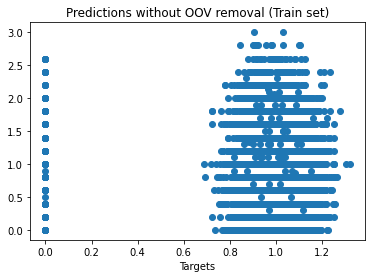

In [118]:
#plot predictions train set
plt.scatter(train_embedding_df.cos_distance.to_list(), train_embedding_df.meanGrade.to_list())
plt.title('Predictions without OOV removal (Train set)')
plt.xlabel('Predictions')
plt.xlabel('Targets')
#Cosine distance where we have double edit, left line is where the model predicts cosine 0 because twice OOV

Text(0.5, 0, 'Targets')

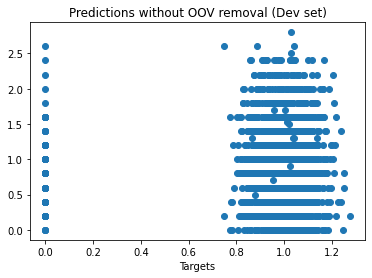

In [119]:
#plot predictions dev set
plt.scatter(dev_embedding_df.cos_distance.to_list(), dev_embedding_df.meanGrade.to_list())
plt.title('Predictions without OOV removal (Dev set)')
plt.xlabel('Predictions')
plt.xlabel('Targets')

In [120]:
train_embedding_df.loc[train_embedding_df.cos_distance == 0.0]

,index,id,original,edit,grades,meanGrade,old,cos_distance,edit_word_corpus_rep,old_word_corpus_rep
9,3223,3501,Pakistan 's Gig Economy Helps Smash Obstacles ...,Imbeciles,32100,1.2,Women,0.0,<OOV>,<OOV>
81,5540,8035,Master Your Very Own Weight-Loss Destiny With ...,Oracles,0,0.0,Tips,0.0,<OOV>,<OOV>
96,8563,9770,Chinese state media : Trump is ' wrong ' when ...,zipper,21111,1.2,North Korea,0.0,<OOV>,<OOV>
103,7903,5515,Trump Lawyers Want A Second Special Counsel,toupee,32110,1.4,Lawyers,0.0,<OOV>,<OOV>
109,5446,9041,Trump Nominees Make Clear Plans to Sweep Away ...,dustpan,11110,0.8,Plans,0.0,<OOV>,<OOV>
...,...,...,...,...,...,...,...,...,...,...
7651,2776,10790,The Republican Ethics Vote : What Happened ?,Bikini,22110,1.2,Ethics,0.0,<OOV>,<OOV>
7677,1168,3907,How states can fix the Electoral College and p...,fruitcake,33110,1.6,Trumps,0.0,<OOV>,<OOV>
7679,2853,1392,Useful Idiots Galore - The New York Times,Inhabitants,33110,1.6,Times,0.0,<OOV>,<OOV>
7682,2138,1767,"Impeach Trump If Mueller Is Fired , Says Ethic...",Yawns,21100,0.8,Says,0.0,<OOV>,<OOV>


In [61]:
#drop headlines with OOV for to replaced word and edit word
indexNames = train_embedding_df[(train_embedding_df['cos_distance'] == 0.0)].index
# Delete these row indexes from dataFrame
train_embedding_df.drop(indexNames , inplace=True)
train_embedding_df.reset_index(inplace=True,drop=True)
pd.set_option('display.max_rows', 20)

In [62]:
#drop headlines with OOV for to replaced word and edit word
indexNames = dev_embedding_df[(dev_embedding_df['cos_distance'] == 0.0)].index
# Delete these row indexes from dataFrame
dev_embedding_df.drop(indexNames , inplace=True)
dev_embedding_df.reset_index(inplace=True,drop=True)
pd.set_option('display.max_rows', 20)

In [63]:
dev_embedding_df.loc[dev_embedding_df.cos_distance == 0.0]

,index,id,original,edit,grades,meanGrade,old,cos_distance,edit_word_corpus_rep,old_word_corpus_rep


In [64]:
#train model using linear regression 
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
model = linear_model.LinearRegression()
#train, test = train_test_split(train_df, test_size=0.2)
dist_train = np.reshape(train_embedding_df.cos_distance.to_list(), (-1,1))
dist_test = np.reshape(dev_embedding_df.cos_distance.to_list(), (-1,1))
y = np.reshape(train_embedding_df.meanGrade.to_list(), (-1,1))
y_test = np.reshape(dev_embedding_df.meanGrade.to_list(), (-1,1))


model.fit(dist_train, y)
predictions = model.predict(dist_test)

mean_squared_error(y_test, predictions, squared = False)


0.5939356525443877

Text(0.5, 0, 'Targets')

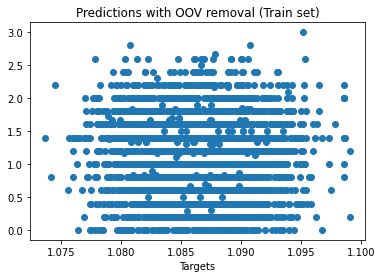

In [65]:
plt.scatter(predictions,y_test)
plt.title('Predictions with OOV removal (Train set)')
plt.xlabel('Predictions')
plt.xlabel('Targets')

In [66]:
#Only look at headlines where both original word and edited word has an embedding
filt_train_df = train_embedding_df[train_embedding_df['edit_word_corpus_rep'] != '<OOV>'][train_embedding_df['old_word_corpus_rep'] != '<OOV>']
filt_train_df = filt_train_df.reset_index(drop = True)
print(len(filt_train_df))
filt_train_df

9110


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,index,id,original,edit,grades,meanGrade,old,cos_distance,edit_word_corpus_rep,old_word_corpus_rep
0,15832,106180,McConnell backs measure to change Senate rules...,bathing,32211,1.800000,article,0.956669,bathing,article
1,13686,104034,Australian Prime Minister Scott Morrison absco...,go,110000,0.333333,rage,1.060205,go,rage
2,11377,101725,"As Sondland testified , a misleading Ukraine s...",butter,22110,1.200000,Ukraine,0.897734,butter,ukraine
3,4415,7324,Trump defends national security adviser H.R. M...,bullet,0,0.000000,call,0.887624,bullet,call
4,8012,9691,Roseanne Barr Smacks Down ‘ A ** hole ’ Michel...,marriage,22110,1.200000,Comedy,1.150960,marriage,comedy
...,...,...,...,...,...,...,...,...,...,...
9105,104,14890,Trump Chief of Staff John Kelly calls Confeder...,hair,33320,2.200000,Staff,0.993918,hair,staff
9106,14418,104766,The US officially raises the tobacco buying ag...,candy,22210,1.400000,tobacco,1.075721,candy,tobacco
9107,7777,2619,Trump rolls back Obama 's Cuba thaw,ice,11110,0.800000,Cuba,1.155475,ice,cuba
9108,8956,1401,Reality Check : Has Trump kept six key promise...,staffer,32200,1.400000,promise,0.928046,staffer,promise


In [67]:
#Only look at headlines where both original word and edited word has an embedding
filt_dev_df = dev_embedding_df[dev_embedding_df['edit_word_corpus_rep'] != '<OOV>'][dev_embedding_df['old_word_corpus_rep'] != '<OOV>']
filt_dev_df = filt_dev_df.reset_index(drop = True)
print(len(filt_dev_df))
filt_dev_df

2270


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,index,id,original,edit,grades,meanGrade,old,cos_distance,edit_word_corpus_rep,old_word_corpus_rep
0,5342,7419,Advice for Trump : Do n't fire Robert Mueller ...,kiss,22110,1.2,clear,1.053983,kiss,clear
1,8320,12252,TRUMP FUMES AT MUELLER AFTER COHEN RAID : ' It...,suit,31000,0.8,country,0.946175,suit,country
2,7893,7133,Trump and Sessions are weaving immigration pol...,music,21000,0.6,immigration,1.137699,music,immigration
3,6481,8118,Woman thrown out of West Virginia town hall me...,bar,31000,0.8,meeting,0.869427,bar,meeting
4,16049,106397,"After a Decade of Hiring , Plenty of Jobs but ...",Many,0,0.0,Plenty,1.182899,many,plenty
...,...,...,...,...,...,...,...,...,...,...
2265,6517,8812,DNC data guru denies Hillary Clinton 's claim ...,country,22100,1.0,nothing,0.914586,country,nothing
2266,12211,102559,"After Trump Pressure , Favorite Fox News Guest...",pizza,31111,1.4,Contract,1.039880,pizza,contract
2267,6588,5480,"On Superstorm Sandy Anniversary , New York Is ...",kitty,22000,0.8,City,1.061116,kitty,city
2268,4841,6020,Trump tweetstorms wash away White House press ...,disappearance,11000,0.4,briefing,1.050213,disappearance,briefing


In [68]:
#Run test only on edited headline where edit was previously seen
model_filt = linear_model.LinearRegression()
#train, test = train_test_split(filt_train_df,test_size = 0.2)
dist_train = np.reshape(filt_train_df.cos_distance.to_list(), (-1,1))
dist_test = np.reshape(filt_dev_df.cos_distance.to_list(), (-1,1))
y = np.reshape(filt_train_df.meanGrade.to_list(), (-1,1))
y_test = np.reshape(filt_dev_df.meanGrade.to_list(), (-1,1))
#print(train.cos_distance)

model.fit(dist_train, y)
predictions = model.predict(dist_test)

mean_squared_error(y_test, predictions, squared = False)

0.5817698273402553

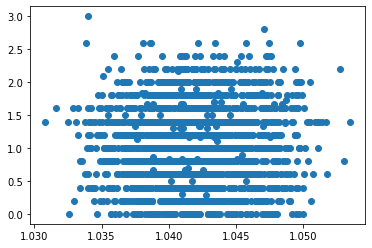

In [69]:
plt.scatter(predictions,y_test)

## Predictions by BILSTM

In [49]:
#Customized tokenizer as in part 1

def custom_tokenizer(nlp):
    
    replacement_re = re.compile(r'^<*/>') #do not split replacement format
    prefix_re = re.compile(r'''^[\[\("]''')
    suffix_re = re.compile(r''',[\]\)"']$''')
    infix_re = re.compile(r'''[-\,.~]''')
    
    
    return Tokenizer(nlp.vocab,
                     token_match = replacement_re.match,
                     prefix_search=prefix_re.search,
                     suffix_search=suffix_re.search,
                     infix_finditer = infix_re.finditer  
                    )


#customized preprocessor as in part 1
def preprocessor(data,edits):
    """
    Creating a corpus of all the tokens used
    """
    from nltk.stem import WordNetLemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()  

    punctuation = "\":\.,"
    nlp = spacy.load("en_core_web_sm")
    nlp.tokenizer = custom_tokenizer(nlp)
    
    tokenized_corpus_1= [] # Let us put the tokenized corpus in a list
    tokenized_corpus_2= []
    
    
    for i, sentence in enumerate(data):

        sentence = sentence.lower()
        tokenized_sentence_1 = []
        tokenized_sentence_2 = []

        for token in nlp(sentence): # simplest split is

            if token.text in punctuation:
                continue
            if token.text in spacy_stop_words:
                continue
            
            else:
                if token.text[0] == '<':
                    tokenized_sentence_1.append("???")
                    tokenized_sentence_2.append("???")
                    
                    tokenized_sentence_2.append(wordnet_lemmatizer.lemmatize(edits.iloc[i],  pos="v"))

                    lemmatized_token = wordnet_lemmatizer.lemmatize(token.text[1:-2], pos="v")

                    tokenized_sentence_1.append(lemmatized_token)
                else:
                    lemmatized_token = wordnet_lemmatizer.lemmatize(token.text, pos="v")

                    tokenized_sentence_2.append(lemmatized_token)
                
                    tokenized_sentence_1.append(lemmatized_token)


        tokenized_corpus_1.append(tokenized_sentence_1)
        tokenized_corpus_2.append(tokenized_sentence_2)

    # Create single list of all vocabulary
    vocabulary = [] 

    for sentence in tokenized_corpus_1:

        for token in sentence:

            if token not in vocabulary:

                if True:
                    vocabulary.append(token)
    
    for token in edits:
        
        if token not in vocabulary:
            
            vocabulary.append(token)

    return vocabulary, tokenized_corpus_1, tokenized_corpus_2

In [53]:
# We set our training data and test data
training_data = train_embedding_df_pre['original']
test_data = dev_embedding_df_pre['original']

training_vocab, training_tokenized_corpus_1,training_tokenized_corpus_2 =  preprocessor(training_data, train_embedding_df_pre['edit'])
test_vocab, test_tokenized_corpus_1,test_tokenized_corpus_2 =  preprocessor(test_data,dev_embedding_df_pre['edit'])


print("Vocab created.")

Vocab created.


In [54]:
#create vektorized sequences as before
vectorized_seqs_1_train = [[word2idx[tok] if tok in word2idx else word2idx[OOV_token] for tok in seq] for seq in training_tokenized_corpus_1]
vectorized_seqs_2_train = [[word2idx[tok] if tok in word2idx else word2idx[OOV_token] for tok in seq] for seq in training_tokenized_corpus_2]

vectorized_seqs_1_test = [[word2idx[tok] if tok in word2idx else word2idx[OOV_token] for tok in seq] for seq in test_tokenized_corpus_1]
vectorized_seqs_2_test = [[word2idx[tok] if tok in word2idx else word2idx[OOV_token] for tok in seq] for seq in test_tokenized_corpus_2]




# To avoid any sentences being empty (if no words match to our word embeddings)
vectorized_seqs_1_train = [x if len(x) > 0 else [0] for x in vectorized_seqs_1_train]
vectorized_seqs_2_train = [x if len(x) > 0 else [0] for x in vectorized_seqs_2_train]

vectorized_seqs_1_test = [x if len(x) > 0 else [0] for x in vectorized_seqs_1_test]
vectorized_seqs_2_test = [x if len(x) > 0 else [0] for x in vectorized_seqs_2_test]


In [73]:
#initialize model with our own trained embedding
INPUT_DIM = len(word2idx)
EMBEDDING_DIM = 128

BATCH_SIZE = 128

model = BiLSTM_double(EMBEDDING_DIM, 55, INPUT_DIM, BATCH_SIZE, device)

params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(params)
#print("Total number of parameters is: {​​}​​".format(params))

print(model)

print("Model initialised.")

model.to(device)
# We provide the model with our embeddings
model.embedding.weight.data.copy_(weights_matrix)


5399517
BiLSTM_double(
  (embedding): Embedding(31457, 128, padding_idx=0)
  (lstm_1): LSTM(128, 55, bidirectional=True)
  (lstm_2): LSTM(128, 55, bidirectional=True)
  (fc): Linear(in_features=11000, out_features=110, bias=True)
  (hidden2label): Linear(in_features=110, out_features=1, bias=True)
  (d1): Dropout(p=0.5, inplace=False)
  (d2): Dropout(p=0.5, inplace=False)
  (d3): Dropout(p=0.5, inplace=False)
)
Model initialised.


tensor([[ 2.9052e-03,  2.9197e-03,  1.5550e-03,  ..., -2.3535e-03,
          2.2624e-06, -1.5256e-03],
        [-2.4886e-03,  4.3952e-04, -3.0382e-04,  ..., -9.5861e-04,
          5.3797e-03,  5.3125e-04],
        [-1.0930e-03,  3.0053e-03,  4.8244e-03,  ..., -1.4892e-03,
          3.1121e-03,  4.7919e-03],
        ...,
        [-2.4952e-03,  2.1709e-03, -5.4640e-03,  ..., -2.9118e-03,
          3.8731e-03,  4.0919e-03],
        [ 3.0573e-04,  2.4652e-03, -1.9072e-03,  ..., -7.2252e-04,
          3.2804e-03, -1.3851e-03],
        [ 3.7596e-03, -3.1394e-03, -2.8640e-03,  ..., -4.2028e-03,
          1.1552e-03, -2.8900e-03]], device='cuda:0', grad_fn=<CopyBackwards>)

In [80]:
#train model
epochs = 200
train_proportion = 0.8

train_dataset = Task1Dataset_double(vectorized_seqs_1_train,vectorized_seqs_2_train, train_embedding_df_pre['meanGrade'])
dev_dataset = Task1Dataset_double(vectorized_seqs_1_test,vectorized_seqs_2_test, dev_embedding_df_pre['meanGrade'])


train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

print("Dataloaders created.")

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.008, momentum=0.9)

train_losses, valid_losses, preds, targs, train_rmses, valid_rmses = train(train_loader, dev_loader, model, epochs)


#Without stop words removal 0.6

Dataloaders created.
Training model.
| Epoch: 01 | Train Loss: 0.42 | Train MSE: 0.42 | Train RMSE: 0.65 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 02 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 03 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 04 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.60 |
| Epoch: 05 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 06 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 07 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 08 | Train Loss: 0.36 | Train 

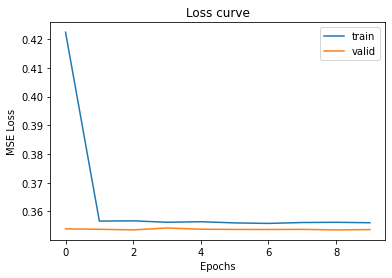

In [82]:
#plot helper function
def plot(train_losses,valid_losses,num_epochs):
  epochs = list(range(num_epochs))
  plt.plot(epochs,train_losses, label='train')
  plt.plot(epochs,valid_losses, label='valid')
  plt.legend()
  plt.title('Loss curve')
  plt.ylabel('MSE Loss')
  plt.xlabel('Epochs')
  plt.show()

plot(train_losses, valid_losses, len(train_losses))

In [83]:
#eval model on dev dataset and plot predicitons
model.eval()
predictions_plot = []  
target_plot = []

with torch.no_grad():
    for batch in dev_loader:
        feature, target = batch
        feature_1= feature[0].to(device)
        feature_2 = feature[1].to(device)
        target = target.to(device)

        feature = (feature_1, feature_2)

        # for RNN:
        model.batch_size = target.shape[0]
        model.hidden_1 = model.init_hidden()
        model.hidden_2 = model.init_hidden()

        predictions = model(feature).squeeze(1)

        predictions_plot.append(predictions.detach().cpu().numpy())
        target_plot.append(target.detach().cpu().numpy())


Text(0.5, 0, 'Predictions')

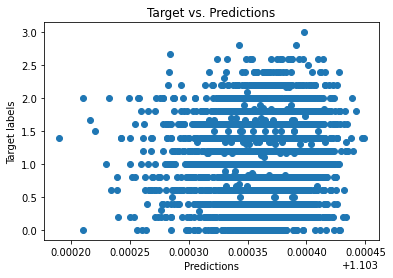

In [86]:
#plot predicitons on dev dataset
pred = np.concatenate(predictions_plot, axis=0)
trg = np.concatenate(target_plot, axis=0)

plt.scatter(pred,trg)
#plt.axis('equal')
plt.title('Target vs. Predictions')
plt.ylabel('Target labels')
plt.xlabel('Predictions')

## Baseline given


In [87]:
#overall rmse when always predicting the mean
mean = train_df['meanGrade'].mean()
sum = 0
for i in range(len(train_df['meanGrade'])):
    sum += (mean - train_df['meanGrade'].loc[i])**2
np.sqrt(sum / len(train_df['meanGrade']))

0.5960374597860942

In [ ]:
train_and_dev = train_df['edit']
train_proportion = 0.8
training_data, dev_data, training_y, dev_y = train_test_split(train_df['edit'], train_df['meanGrade'],
                                                                        test_size=(1-train_proportion),
                                                                        random_state=42)

# We train a Tf-idf model
count_vect = CountVectorizer(stop_words='english')
train_counts = count_vect.fit_transform(training_data)
transformer = TfidfTransformer().fit(train_counts)
transformer
train_counts = transformer.transform(train_counts)
regression_model = LinearRegression().fit(train_counts, training_y)
print(train_counts)

  (0, 6912)	0.3196422657133493
  (0, 6889)	0.4635074138381324
  (0, 6423)	0.11278822224285272
  (0, 5804)	0.44285750586411565
  (0, 5374)	0.23652438242454743
  (0, 5312)	0.3400955840429778
  (0, 4309)	0.34740743437045796
  (0, 4089)	0.2845496729305107
  (0, 3299)	0.31761063288602626
  (1, 6541)	0.48194793383580115
  (1, 5549)	0.3204233579379913
  (1, 5014)	0.42370065991381706
  (1, 2759)	0.4595615370435467
  (1, 2464)	0.5237709472831734
  (2, 6892)	0.35794538379097757
  (2, 6156)	0.36483747544305006
  (2, 5741)	0.3829658592421385
  (2, 5499)	0.3419984129026347
  (2, 4801)	0.3829658592421385
  (2, 4305)	0.291413316187634
  (2, 3322)	0.313301064206565
  (2, 2076)	0.3110077361041403
  (2, 1141)	0.2206241510260133
  (3, 6534)	0.39337308644812724
  (3, 6423)	0.09734562388426601
  :	:
  (7717, 6019)	0.520234681094425
  (7717, 5375)	0.28639284053699743
  (7717, 3451)	0.4360369675276321
  (7717, 3299)	0.3331918391659665
  (7717, 2782)	0.46458301954981385
  (7717, 2533)	0.3610437600682453
  (77

In [ ]:

# Train predictions
predicted_train = regression_model.predict(train_counts)

# Calculate Tf-idf using train and dev, and validate model on dev:
test_and_test_counts = count_vect.transform(train_and_dev)
transformer = TfidfTransformer().fit(test_and_test_counts)

test_counts = count_vect.transform(dev_data)

test_counts = transformer.transform(test_counts)

# Dev predictions
predicted = regression_model.predict(test_counts)

# We run the evaluation:
print("\nTrain performance:")
sse, mse, _ = model_performance(predicted_train, training_y, True)

print("\nDev performance:")
sse, mse, _ = model_performance(predicted, dev_y, True)


Train performance:
| MSE: 0.16 | RMSE: 0.40 |

Dev performance:
| MSE: 0.48 | RMSE: 0.69 |


#### Baseline for task 2

In [ ]:
# Baseline for the task
pred_baseline = torch.zeros(len(dev_y)) + np.mean(training_y)
print("\nBaseline performance:")
sse, mse = model_performance(pred_baseline, dev_y, True)

## Submission Codalab


In [ ]:

def submission_task_1(train_loc, test_loc):
    train = pd.read_csv(train_loc)    
    test = pd.read_csv(test_loc)

    pred = bert_predictions  
    test['pred'] = pred
    
    output = test[['id','pred']] 
    out_loc = '../output/task-1-output.csv'
    output.to_csv(out_loc, index=False)
    
    print('Output file created:\n\t- '+os.path.abspath(out_loc))